In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [2]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')

cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [25]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p,process, sent_cut, modis_sen):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs

solved = []
to_regs = []
for ii,sen_cut in enumerate(patch15Sen):
    p = np.array([140., 240.,45., -20.,56.])
    #bound = np.array([(14., 400.),(8.,400.),(20.,160.), (-50, 100), (-50, 100)])
    psolve = optimize.fmin_powell(cost,p,full_output=1,xtol = 1e-08, 
                                    args=(([1,5],), sen_cut, modis_sent[ii]))
    solved.append(psolve)
    to_regs.append(to_regression)
    print 'solved one: ', psolve, '\n'

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.  240.   45.  -20.   56.] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.  240.   45.  -20.   56.] 

patch 15
costs: 0.0241865832026 rvalue:  0.975813416797 slop:  1.27942291708 
parameters:  [ 141.  240.   45.  -20.   56.] 

patch 15
costs: 0.024180577734 rvalue:  0.975819422266 slop:  1.27941588463 
parameters:  [ 138.381966  240.         45.        -20.         56.      ] 

patch 15
costs: 0.0241742349719 rvalue:  0.975825765028 slop:  1.27940842561 
parameters:  [ 135.76393197  240.           45.          -20.           56.        ] 

patch 15
costs: 0.0241631918624 rvalue:  0.975836808138 slop:  1.27939536112 
parameters:  [ 131.52786391  240.           45.          -20.           56.        ] 

patch 15
costs: 0.0241429923892 rvalue:  0.975857007611 slop:  1.27937120577 
parameters:  [ 124.67376175  240.           45.          -20.  

<ipython-input-25-a567a07962c4>:58: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [31]:
print np.array([i[0] for i in solved])

[[  1.99253440e+01   2.26712680e+01   4.82264824e+01  -2.00000000e+01
    5.60000000e+01]
 [  1.70607836e+01   3.06895983e+01   1.09353955e+01  -1.89999953e+01
    5.91443100e+01]
 [  1.77647361e+01   3.32600598e+01   1.25699170e+01  -2.16180310e+01
    5.60000050e+01]
 [  2.25994274e+01   2.34573426e+01   4.82264824e+01  -2.37609310e+01
    5.60000000e+01]
 [ -1.77978656e+01   3.28631958e+01   8.70533159e+00  -2.38540951e+01
    5.72360730e+01]
 [  9.08588837e+08   4.71440669e+01   6.68599681e+01  -2.20000000e+01
    7.25433803e+01]
 [  1.07510780e+08   2.91098684e+01   8.97978974e+01  -1.47639242e+01
    7.27760826e+01]]


/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


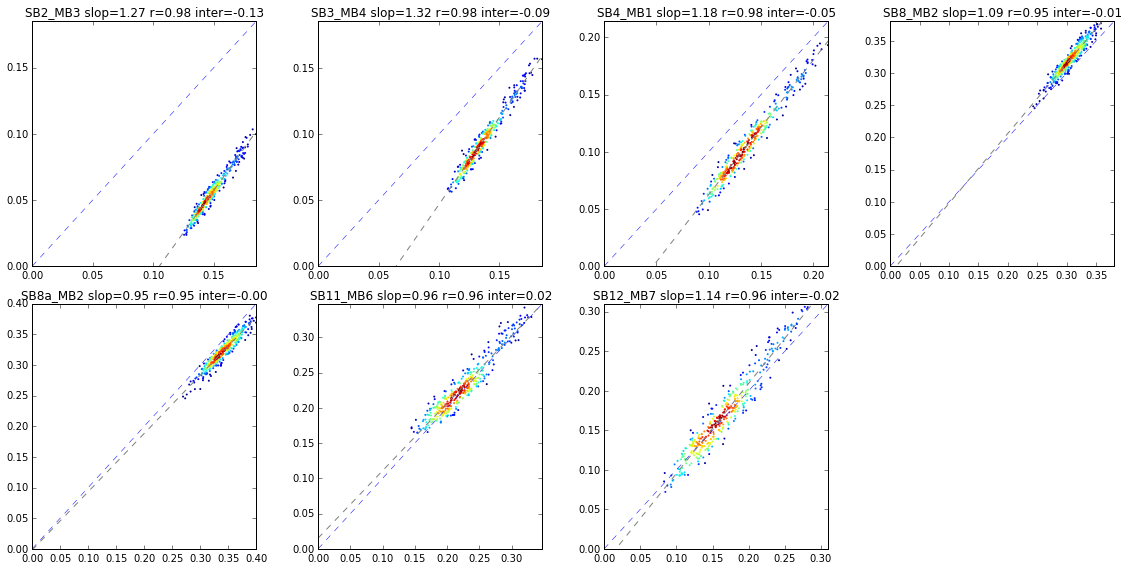

In [24]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')